# Solving the Diet Problem with *sasoptpy*

Diet problem, also known as *Stigler diet problem*, is one of the earliest optimization problems in the literature. [George J. Stigler](https://en.wikipedia.org/wiki/George_Stigler) originally posed the question of finding the cheapest diet, while satisfying the minimum nutritionial requirements [(Stigler, 1945)](www.jstor.org/stable/1231810).

This well-known problem can be solved with Linear Optimization easily. Since methodology was not developed in 1937, Stigler solved this problem using heuristics, albeit his solution was not the optimal (best) solution. He only missed the best solution by 24 cents per year.

Here, we will see how the problem can written in terms of mathematical equations and fed into SAS Viya Optimization solvers using the modeling capabilities of *sasoptpy* package.


## Organizing data

In [1]:
# Let us start with the nutritionial requrirements

# We use pandas package to represent tabular data
import pandas as pd

req = pd.DataFrame([
    ['calories', 3, 'kilocalories'],
    ['protein', 70, 'grams'],
    ['calcium', 0.8, 'grams'],
    ['iron', 12, 'milligrams'],
    ['vitamin_A', 5, 'thousand IU'],
    ['vitamin_B1', 1.8, 'milligrams'],
    ['vitamin_B2', 2.7, 'milligrams'],
    ['niacin', 18, 'milligrams'],
    ['vitamin_C', 75, 'milligrams']
], columns=['nutrient', 'allowance', 'unit']).set_index('nutrient')

# Print the table

from IPython.display import display, HTML
display(req)

,allowance,unit
nutrient,,
calories,3.0,kilocalories
protein,70.0,grams
calcium,0.8,grams
iron,12.0,milligrams
vitamin_A,5.0,thousand IU
vitamin_B1,1.8,milligrams
vitamin_B2,2.7,milligrams
niacin,18.0,milligrams
vitamin_C,75.0,milligrams


The `diet.csv` file includes nutritional information from Stigler's 1945 paper. Each nutrient information is listed for $1 equivalent of the listed foods.

In [2]:
# Load the nutritional information from the file
nutr = pd.read_csv('diet.csv', index_col=0)
nutr.columns = req.index.tolist()

# Print first 10 rows for reference
display(nutr.head(10))

,calories,protein,calcium,iron,vitamin_A,vitamin_B1,vitamin_B2,niacin,vitamin_C
Wheat Flour (Enriched),44.7,1411,2.0,365,0.0,55.4,33.3,441,0
Macaroni,11.6,418,0.7,54,0.0,3.2,1.9,68,0
Wheat Cereal (Enriched),11.8,377,14.4,175,0.0,14.4,8.8,114,0
Corn Flakes,11.4,252,0.1,56,0.0,13.5,2.3,68,0
Corn Meal,36.0,897,1.7,99,30.9,17.4,7.9,106,0
Hominy Grits,28.6,680,0.8,80,0.0,10.6,1.6,110,0
Rice,21.2,460,0.6,41,0.0,2.0,4.8,60,0
Rolled Oats,25.3,907,5.1,341,0.0,37.1,8.9,64,0
White Bread (Enriched),15.0,488,2.5,115,0.0,13.8,8.5,126,0
Whole Wheat Bread,12.2,484,2.7,125,0.0,13.9,6.4,160,0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000185C3B62C18>,
      dtype=object)

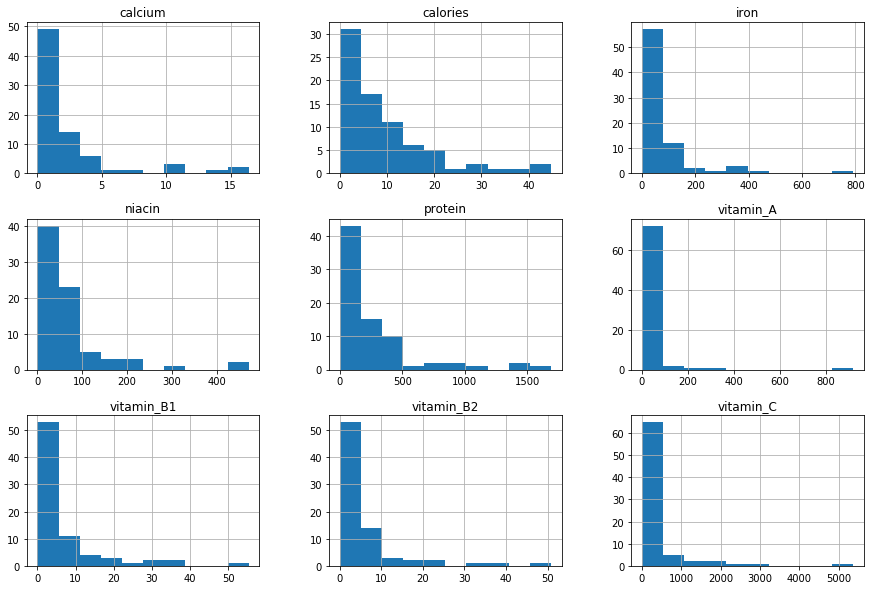

In [3]:
%matplotlib inline
# Show histogram of available values
import matplotlib.pyplot as plt
h = nutr.hist(figsize=(15,10))
display(h)

## Problem formulation

The diet problem can be written as a linear optimization formulation.

Denote $x_i$ as the servings of food item $i$ in our daily diet. The total cost of the diet is
$$
\sum_{i} c_i x_i
$$
where $c_i$ is the cost per serving of food item $i$.

Using the nutritional info, let us denote $n_{ij}$ as the amount of nutrition $j$ in food item $i$. Since we are trying to satisfy the minimum daily intake, we can write this constraint using the following mathematical expression:
$$
\sum_{i} n_{ij} x_i \geq m_j
$$
where $m_j$ is the minimum intake for nutrient $j$.

We can write the linear optimization model as follows

$$
\begin{array}{rrclcl}
\displaystyle \textrm{minimize}_{x} & \displaystyle {\sum_{i \in F} c_i x_i} \\
\textrm{subject to:} & \displaystyle \sum_{i \in F} n_{ij} x_i & \geq & m_j & & \forall j \in N \\
\end{array}
$$

## Modeling with Python

In [4]:
# We use sasoptpy to solve this problem
import sys
sys.path.insert(0, r'../../')
import sasoptpy as so
so.reset()

# We need swat package for connecting a running SAS Viya instance
from swat import CAS

# We will connect to the server
import os
host = os.environ['CASHOST']
port = os.environ['CASPORT']
session = CAS(host, port)

In [5]:
# Create a model object
m = so.Model(name='diet_problem', session=session)

NOTE: Initialized model diet_problem.


In [6]:
# Define sets
F = nutr.index.tolist()
N = nutr.columns.tolist()

In [7]:
# Define variables
x = m.add_variables(F, name='intake', lb=0)

In [8]:
# Define objective
total_cost = m.set_objective(so.expr_sum(x[i] for i in F), sense=so.MIN, name='total_cost')

In [9]:
# Add the constraint
nutrient_con = m.add_constraints(
    (so.expr_sum(nutr.at[i, j] * x[i] for i in F) >= req['allowance'][j] for j in N), name='nutrient_con'
)

In [10]:
# Solve the problem
sol = m.solve()

NOTE: Added action set 'optimization'.
NOTE: Converting model diet_problem to OPTMODEL.
NOTE: Submitting OPTMODEL code to CAS server.
NOTE: Problem generation will use 8 threads.
NOTE: The problem has 77 variables (0 free, 0 fixed).
NOTE: The problem has 9 linear constraints (0 LE, 0 EQ, 9 GE, 0 range).
NOTE: The problem has 570 linear constraint coefficients.
NOTE: The problem has 0 nonlinear constraints (0 LE, 0 EQ, 0 GE, 0 range).
NOTE: The OPTMODEL presolver is disabled for linear problems.
NOTE: The LP presolver value AUTOMATIC is applied.
NOTE: The LP presolver time is 0.01 seconds.
NOTE: The LP presolver removed 20 variables and 0 constraints.
NOTE: The LP presolver removed 120 constraint coefficients.
NOTE: The presolved problem has 57 variables, 9 constraints, and 450 constraint coefficients.
NOTE: The LP solver is called.
NOTE: The Dual Simplex algorithm is used.
                              Objective
         Phase Iteration        Value         Time
          D 2          

## Solution

The daily cost of our diet is 0.1086 USD (in 1939 dollars). It is equivalent to only 39.66 USD per year.

In [11]:
# Let us print the selected food items
for i in F:
    if x[i].get_value() > 0:
        print(i, round(x[i].get_value(), 4))

Wheat Flour (Enriched) 0.0295
Liver (Beef) 0.0019
Cabbage 0.0112
Spinach 0.005
Navy Beans, Dried 0.061


In [12]:
# Let us visualize the results
res = []
for i in F:
    if x[i].get_value() > 0:
        res.append([i, x[i].get_value(),])

resdf = pd.DataFrame(res, columns=['food', 'cost']).set_index(['food'])
resdf = resdf.join(nutr)
for i in N:
    resdf['total_'+i] = resdf['cost'] * resdf[i]
    resdf = resdf.drop([i], axis=1)

totaldf = resdf.append(resdf.sum().rename('Total'))

display(totaldf)

,cost,total_calories,total_protein,total_calcium,total_iron,total_vitamin_A,total_vitamin_B1,total_vitamin_B2,total_niacin,total_vitamin_C
food,,,,,,,,,,
Wheat Flour (Enriched),0.029519,1.319502,41.651396,0.059038,10.774458,0.000000,1.635356,0.982985,13.017906,0.000000
Liver (Beef),0.001893,0.004164,0.630222,0.000379,0.263065,0.320221,0.012112,0.096142,0.598048,0.993593
Cabbage,0.011214,0.029158,1.401804,0.044858,0.403720,0.080744,0.100930,0.050465,0.291575,60.210303
Spinach,0.005008,0.005508,0.530812,0.000000,0.691057,4.599035,0.028544,0.069106,0.165253,13.796105
"Navy Beans, Dried",0.061029,1.641668,103.199301,0.695726,48.334622,0.000000,2.343497,1.501303,13.243198,0.000000
Total,0.108662,3.000000,147.413535,0.800000,60.466922,5.000000,4.120439,2.700000,27.315981,75.000000


array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000185C81BD208>,
      dtype=object)

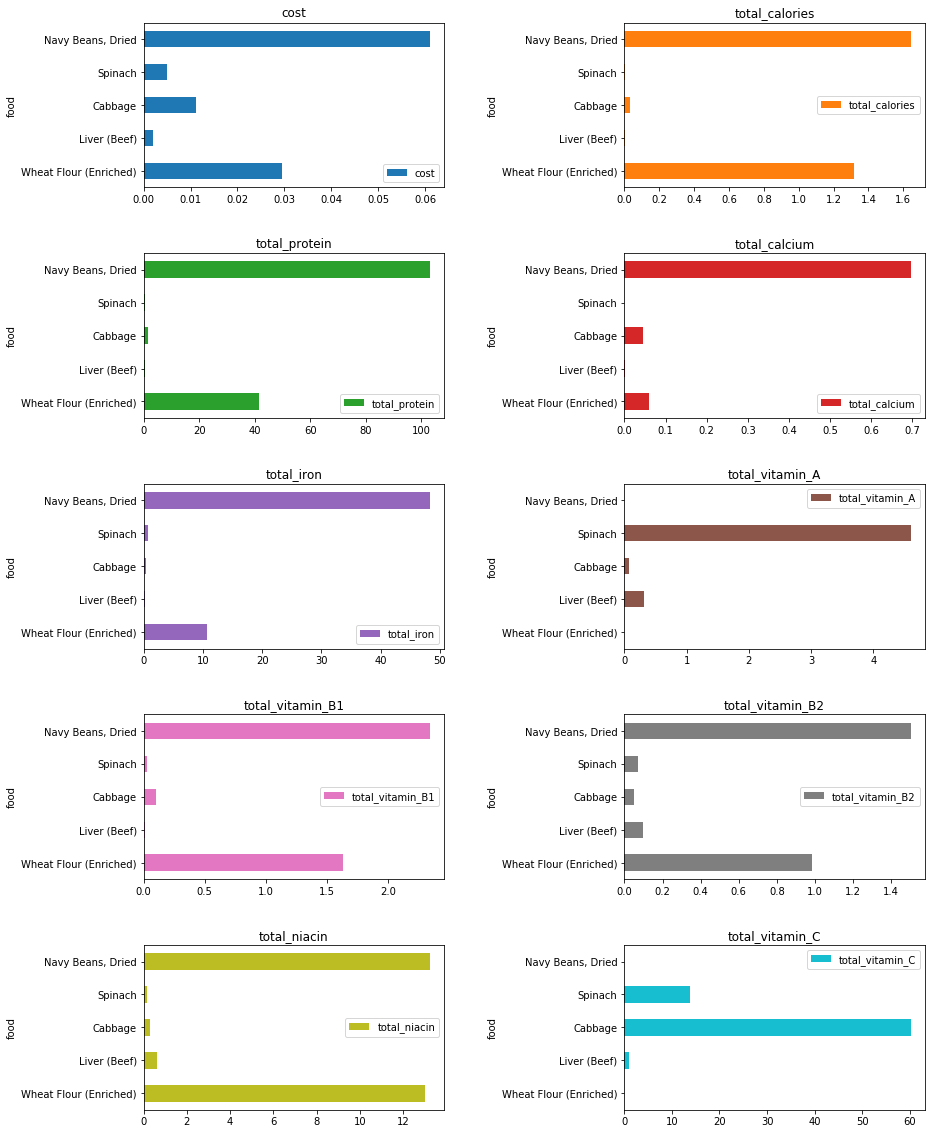

In [13]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(14,20))
plt.subplots_adjust(wspace=0.6, hspace=0.4)
resdf.plot(kind='barh', subplots=True, ax=ax)

Navy beans and wheat flour dominate calories, protein, iron, vitamin B1, vitamin B2, and niacin intake.